# Visualise Importance 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alibi.explainers import PermutationImportance, plot_permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [15]:
tree_import = pd.read_csv('Gini_Importance_Trees.csv', index_col = 0)
shrub_import = pd.read_csv('Gini_Importance_Shrub.csv', index_col = 0)
grass_import = pd.read_csv('Gini_Importance_grass.csv', index_col = 0)

Text(-0.07, 0.5, 'Five Most important Variables')

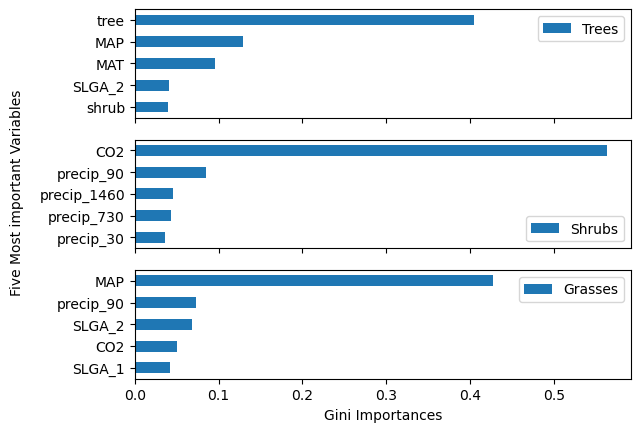

In [20]:
fig, ax = plt.subplots(3, 1, sharex = True)
tree_import.sort_values('Gini_importance', ascending = True)[-5:].plot.barh(ax = ax[0], label = 'trees')
ax[0].legend(["Trees"])
shrub_import.sort_values('Gini_importance', ascending = True)[-5:].plot.barh(ax = ax[1], label = 'shrubs')
ax[1].legend(["Shrubs"])
grass_import.sort_values('Gini_importance', ascending = True)[-5:].plot.barh(ax = ax[2], label = 'grass')
ax[2].legend(["Grasses"])
plt.xlabel('Gini Importances')

fig.text(-0.07, 0.5, 'Five Most important Variables', va='center', rotation='vertical')


In [34]:
tree_import = pd.read_csv('Perm_importance_trees.csv', index_col = 0)
shrub_import = pd.read_csv('Perm_importance_shrubs.csv', index_col = 0)
grass_import = pd.read_csv('Perm_importance_grass.csv', index_col = 0)

Text(-0.08, 0.5, 'Five Most important Variables')

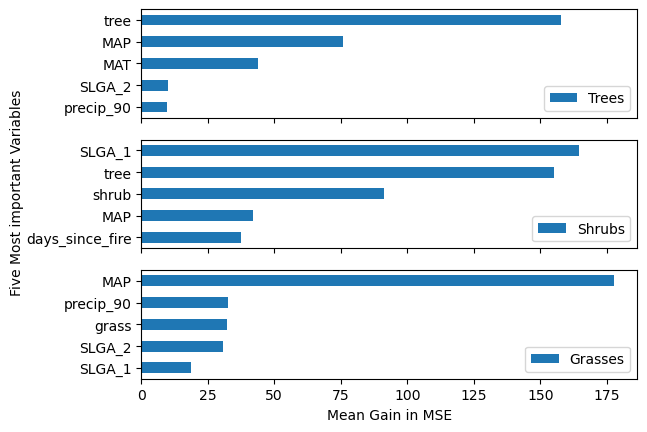

In [63]:
fig, ax = plt.subplots(3, 1, sharex = True)
tree_import.sort_values('importances_mean', ascending = True)[-5:]['importances_mean'].plot.barh(ax = ax[0], label = 'trees')
ax[0].legend(["Trees"])
shrub_import.sort_values('importances_mean', ascending = True)[-5:]['importances_mean'].plot.barh(ax = ax[1], label = 'shrubs')
ax[1].legend(["Shrubs"])
grass_import.sort_values('importances_mean', ascending = True)[-5:]['importances_mean'].plot.barh(ax = ax[2], label = 'grass')
ax[2].legend(["Grasses"])
plt.xlabel('Mean Gain in MSE')

fig.text(-0.08, 0.5, 'Five Most important Variables', va='center', rotation='vertical')


<Axes: >

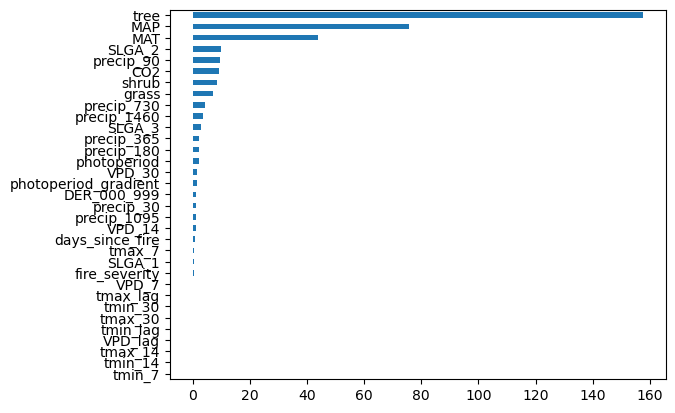

In [65]:
tree_import.sort_values('importances_mean', ascending = True)['importances_mean'].plot.barh(label = 'trees')

<Axes: >

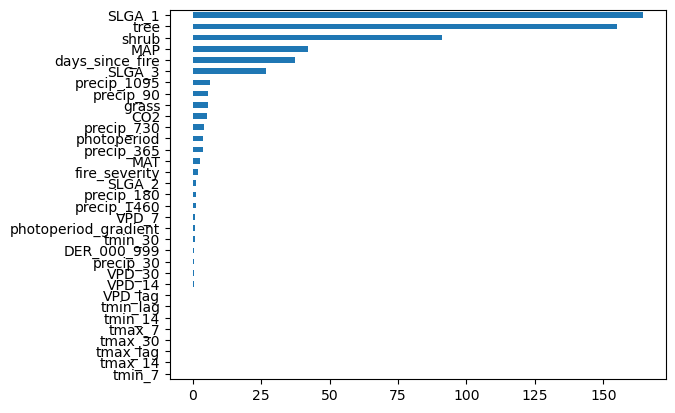

In [66]:
shrub_import.sort_values('importances_mean', ascending = True)['importances_mean'].plot.barh(label = 'trees')

<Axes: >

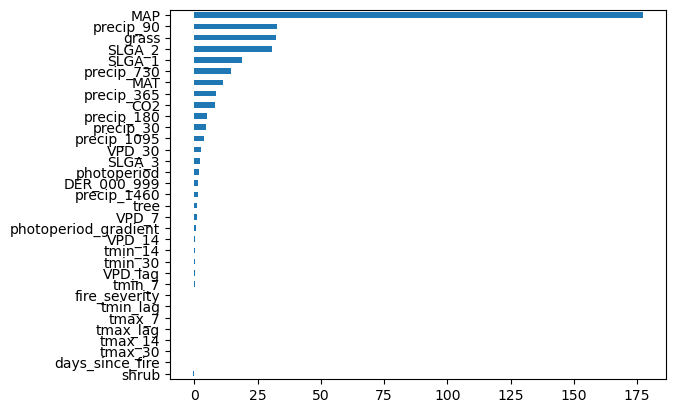

In [67]:
grass_import.sort_values('importances_mean', ascending = True)['importances_mean'].plot.barh(label = 'trees')

In [100]:
precip_var = ['precip_30', 'precip_90', 'precip_180', 'precip_365', 'precip_730', 'precip_1095', 'precip_1460'][::-1]
precip_var_set = ['1-30 days', '31-90 days', '91-180 days', '181-365 days', '366-730 days', '731-1095 days', '1096-1460 days'][::-1]


Text(-0.12, 0.5, 'Precipitation Timescale')

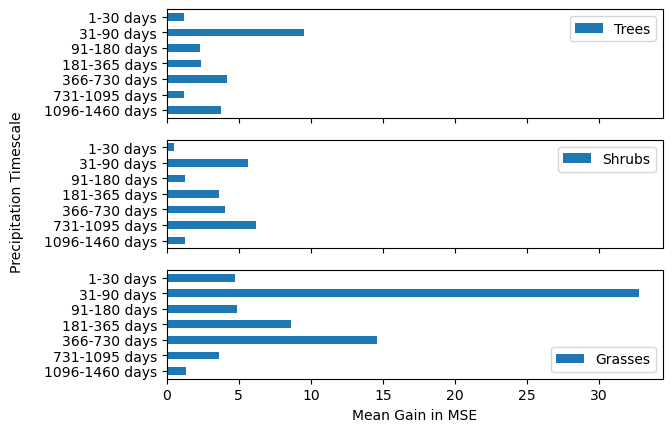

In [121]:

fig, ax = plt.subplots(3, 1, sharex = True)

t = tree_import.loc[precip_var]
t['precip_var_set'] = precip_var_set
t = t.set_index('precip_var_set')
t.index.name = None
t['importances_mean'].plot.barh(ax = ax[0], label = 'trees')
ax[0].legend(["Trees"])

t = shrub_import.loc[precip_var]
t['precip_var_set'] = precip_var_set
t = t.set_index('precip_var_set')
t.index.name = None
t['importances_mean'].plot.barh(ax = ax[1], label = 'shrubs')
ax[1].legend(["Shrubs"])

t = grass_import.loc[precip_var]
t['precip_var_set'] = precip_var_set
t = t.set_index('precip_var_set')
t.index.name = None
t['importances_mean'].plot.barh(ax = ax[2], label = 'grass')
ax[2].legend(["Grasses"])

plt.xlabel('Mean Gain in MSE')
fig.text(-0.12, 0.5, 'Precipitation Timescale', va='center', rotation='vertical')


In [52]:
tree_import.loc[precip_var].sort_values('importances_mean', ascending = False)

,importances_mean,importances_std
precip_90,9.514821,0.362666
precip_730,4.159435,0.381385
precip_1460,3.791268,0.297587
precip_365,2.382179,0.238601
precip_180,2.301208,0.221620
precip_30,1.204809,0.103306
precip_1095,1.184154,0.115693


# Try Permutation Importance by Alibi Explain

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 17:58:38 2024

@author: krish
"""

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import graphviz 

import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')

from sklearn.ensemble import RandomForestRegressor
import random
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold


#%% Functions 

def plotPredictions(actual, prediction, TARGET, msg = '', split = ''):
    fig, ax = plt.subplots(nrows = 3, figsize = (15,10))
    fig.suptitle(msg, fontsize=30)
    for i,v in enumerate(TARGET):
        actual[v].plot(ax=ax[i], color = 'blue', alpha = 0.4, linestyle='dashed' )
        prediction[f'prediction_{v}'].plot(ax=ax[i], color = 'orange', ylim = (0,100))
        ax[i].legend()
        if split:
            for s in split:
                ax[i].axvline(s, color='black', ls='--')

#%% Main 
# Development (after 2015 set)
after_2015_sites = ['WAAPIL0003', 'NSABHC0023', 'TCATCH0006',
                 'WAAGAS0002', 'NSAMDD0014', 'NTAGFU0021', 
                 'NSANSS0001', 'SATSTP0005', 'QDASSD0015', 
                 'NTAFIN0002', 'NSANAN0002', 'QDAEIU0010'] # smalller subset 


tree_sites = ['NSABBS0001', 'NSACOP0001', 'NSAMDD0011', 'NSAMDD0020',
       'NSAMUL0003', 'NSANAN0001', 'NSANAN0002', 'NSANSS0001',
       'NSANSS0002', 'NSTSYB0003', 'NSTSYB0006', 'NTAFIN0003',
       'NTAFIN0015', 'NTAGFU0030', 'NTAGFU0034', 'QDABBN0002',
       'QDACHC0003', 'QDACYP0020', 'QDAGUP0006', 'QDAMGD0025',
       'QDAMUL0002', 'QDAMUL0003', 'QDASEQ0004', 'SAAFLB0008',
       'SATFLB0003', 'SATFLB0020', 'SATFLB0022', 'TCATCH0004',
       'WAACAR0002', 'WAAGAS0001', 'WAAPIL0023']

shrub_sites = ['NSABHC0011', 'NSAMDD0028', 'NSTSYB0005', 'NTAFIN0018',
       'QDABBS0010', 'QDACYP0018', 'QDAGUP0021', 'SAAEYB0021',
       'SAAEYB0028', 'SAAFLB0005', 'SAAGAW0008', 'SAAKAN0009',
       'SAASTP0023', 'SAASTP0033', 'SAASTP0034', 'SASMDD0009',
       'SASMDD0014', 'SATFLB0023', 'WAACAR0004', 'WAACOO0007',
       'WAACOO0016', 'WAACOO0024', 'WAACOO0026', 'WAACOO0027',
       'WAACOO0029', 'WAAGES0001', 'WAALSD0002', 'WAANUL0003',
       'WAAPIL0010']

grass_sites = ['NSABHC0023', 'NSAMDD0001', 'NSAMDD0014', 'NTADAC0001',
       'NTADMR0001', 'NTAFIN0002', 'NTAFIN0006', 'NTAGFU0014',
       'NTAGFU0020', 'NTAGFU0021', 'NTASTU0004', 'NTTDMR0003',
       'QDABBS0002', 'QDACYP0006', 'QDACYP0022', 'QDAEIU0005',
       'QDAEIU0010', 'QDAGUP0009', 'QDAGUP0019', 'QDAMGD0002',
       'QDAMGD0023', 'QDAMGD0024', 'QDASSD0015', 'SAAEYB0029',
       'SAAFLB0003', 'SASMDD0005', 'SATFLB0019', 'SATSTP0005',
       'TCATCH0006', 'TCATNM0001', 'TCATNM0003', 'VCAAUA0012',
       'WAAAVW0006', 'WAACOO0030', 'WAAGAS0002', 'WAANOK0006',
       'WAAPIL0003', 'WAAPIL0024', 'WAAPIL0031']

sites_list = tree_sites

#%% Model the dataset

SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30', 'MAT']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

LAG_FEATURES = ['pv_lag', 'npv_lag', 'bs_lag']

LAGGED_CHANGE_FEATURES = ['pv_change', 'npv_change', 'bs_change']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

VEGETATION_FEATURES = ['grass', 'shrub', 'tree']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + TEMP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + VEGETATION_FEATURES + SOIL_FEATURES # final features 
TARGET = ['pv_filter', 'npv_filter', 'bs_filter']
scores = []


#%% Create Train/test set 


# Training and test set 
datasets =  {} # entire set - for final evaluation 
training_set = {} # training set 
test_set = {} # test set 

# 7 years is roughly 20% of the dataset (of n rows)
# i.e. 161 data points 
# A solution is take a random number of the lower bounds (l), such that l >= 0 and l < n - 161
# The upper bounds (u) is simply u = l + 161 

# Iterate through the site list 


random.seed(20240514)

choices = [0, 161, 322, 483, 644] # approx 20% splits 
number_of_choices = len(sites_list)/len(choices)

after_2015_test = False
after_2015_list = list(set(sites_list).intersection(after_2015_sites)) # the sites where I want to predict 2015-2022

duplicator = [round(np.floor(number_of_choices)) for i in range(len(choices))]
print(duplicator)
# If there are specific sites I want as having 2015 >, I need to force some order 
if after_2015_test:
    if duplicator[-1] < len(after_2015_list):
        duplicator[-1] = len(after_2015_list)
    #number_of_choices_adj = (len(sites_list) - len(after_2015_list))/(len(choices) - 1)
    #for i in range(len(choices) - 1):
     #   duplicator[i] = round(np.floor(number_of_choices_adj))

print(duplicator)
already_chosen = []
print(number_of_choices)
while sum(duplicator) != len(sites_list): # if there is an uneven split, keep adding 1 more until it sums to the avaliable number of datasets 
    chosen_index = random.randrange(0,len(duplicator),1)
    if chosen_index not in already_chosen:
        duplicator[chosen_index] += 1
        already_chosen.append(chosen_index)
    #number_of_choices = len(sites_list)/sum(duplicator)

print(duplicator)

choice_adj = []
for index ,i in enumerate(choices):
    for j in range(duplicator[index]):
        choice_adj.append(i)
        
print(choice_adj)
random.shuffle(choice_adj)
print(choice_adj)

if after_2015_test:
    after_2015_indices = [np.where(sites_list == i)[0][0] for i in after_2015_list]
    for i in range(len(after_2015_list)):
        if choice_adj[after_2015_indices[i]] != choices[-1]:
            print(choice_adj) # swap with an element that is 644 and NOT an index of one the after 2015 sites
            index_choices = set(np.where(np.array(choice_adj)== 644)[0]).difference(after_2015_indices)
            swap_index = random.choice(list(index_choices))
            choice_adj[after_2015_indices[i]], choice_adj[swap_index] =  choice_adj[swap_index], choice_adj[after_2015_indices[i]]


period = 161 # approx. 20% 
for i, site_location_name in enumerate(sites_list):
    site_merged = pd.read_csv(f'Input_DataSet_{site_location_name}.csv', parse_dates = ['time']).copy().dropna(subset = FEATURES) # read and drop na
    site_merged.sort_values('time', inplace = True)
    site_merged.reset_index(inplace = True)

    
    lower_bound = choice_adj[i]
    if lower_bound == choices[-1]: # if its the last 20%, simply take all time points from there up to the most recent time point
        upper_bound = len(site_merged) -1
    else:
        upper_bound = lower_bound + period 
        
    print(f'{site_location_name} : {(site_merged.time[lower_bound], site_merged.time[upper_bound])}')
    
    #print((lower_bound, upper_bound))
    # get test set 
    test = site_merged[(site_merged.index >= lower_bound) & (site_merged.index <= upper_bound)]
    # get train set (note the selection condition is logically opposite to selection condition of the test set )
    train = site_merged[(site_merged.index < lower_bound) | (site_merged.index > upper_bound)]
    
    datasets[site_location_name] = site_merged
    training_set[site_location_name] = train
    test_set[site_location_name] = test
    
training_merged = pd.concat(training_set).dropna(subset = FEATURES) # drop na based on chosen features, needed for random forest 
training_merged.sort_values('time', inplace = True)
training_merged.set_index('time', inplace = True)

test_merged = pd.concat(test_set).dropna(subset = FEATURES)
test_merged.sort_values('time', inplace = True)
test_merged.set_index('time', inplace = True)


#%% Run The model 

random_state = 20240228
main_scorer = 'neg_mean_squared_error'
# Possible scorers:
    #  neg_mean_absolute_percentage_error'
    #  mean_squared_log_error
    # See more below:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    

## Test with Default RF 
reg = RandomForestRegressor(n_estimators = 100, random_state = random_state, n_jobs = 7)

# default_RF_CV = pd.DataFrame(cross_validate(reg, X = training_merged[FEATURES],
#                      y = training_merged[TARGET], cv=cv_splits, 
#                      scoring=np.unique(['neg_mean_squared_error', main_scorer]).tolist(),
#                      return_train_score = True))
# print(f'Default\nTrain R2 {default_RF_CV["train_" + "neg_mean_squared_error"].mean()}\nTest R2 {default_RF_CV["test_" + "neg_mean_squared_error"].mean()}')


#%% Fit the Models

# Default Model 

reg.fit(X = training_merged[FEATURES], y = training_merged[TARGET])

[6, 6, 6, 6, 6]
[6, 6, 6, 6, 6]
6.2
[6, 6, 6, 7, 6]
[0, 0, 0, 0, 0, 0, 161, 161, 161, 161, 161, 161, 322, 322, 322, 322, 322, 322, 483, 483, 483, 483, 483, 483, 483, 644, 644, 644, 644, 644, 644]
[644, 644, 322, 483, 322, 322, 483, 0, 161, 0, 161, 0, 161, 322, 0, 0, 483, 483, 644, 161, 644, 483, 322, 644, 0, 483, 644, 483, 161, 161, 322]
NSABBS0001 : (Timestamp('2015-12-11 00:00:00'), Timestamp('2022-12-30 00:00:00'))
NSACOP0001 : (Timestamp('2015-12-25 00:00:00'), Timestamp('2022-12-28 00:00:00'))
NSAMDD0011 : (Timestamp('2001-11-21 00:00:00'), Timestamp('2008-12-10 00:00:00'))
NSAMDD0020 : (Timestamp('2008-12-05 00:00:00'), Timestamp('2015-12-25 00:00:00'))
NSAMUL0003 : (Timestamp('2001-11-07 00:00:00'), Timestamp('2008-11-26 00:00:00'))
NSANAN0001 : (Timestamp('2001-10-26 00:00:00'), Timestamp('2008-11-14 00:00:00'))
NSANAN0002 : (Timestamp('2008-11-14 00:00:00'), Timestamp('2015-12-04 00:00:00'))
NSANSS0001 : (Timestamp('1987-10-11 00:00:00'), Timestamp('1994-10-30 00:00:00'))
NSAN

RandomForestRegressor(n_jobs=7, random_state=20240228)

In [5]:
pfi = PermutationImportance(predictor= reg.predict,
                                  loss_fns= ['mean_squared_error'],
                                  feature_names=FEATURES,
                                  verbose=True)

In [6]:
exp_tree = pfi.explain(X= np.array(test_merged[FEATURES]),
                  y= np.array(test_merged[TARGET]),
                  method = 'estimate',
                  kind = 'ratio',
                  n_repeats = 50)

100%|██████████| 33/33 [00:29<00:00,  1.12it/s]


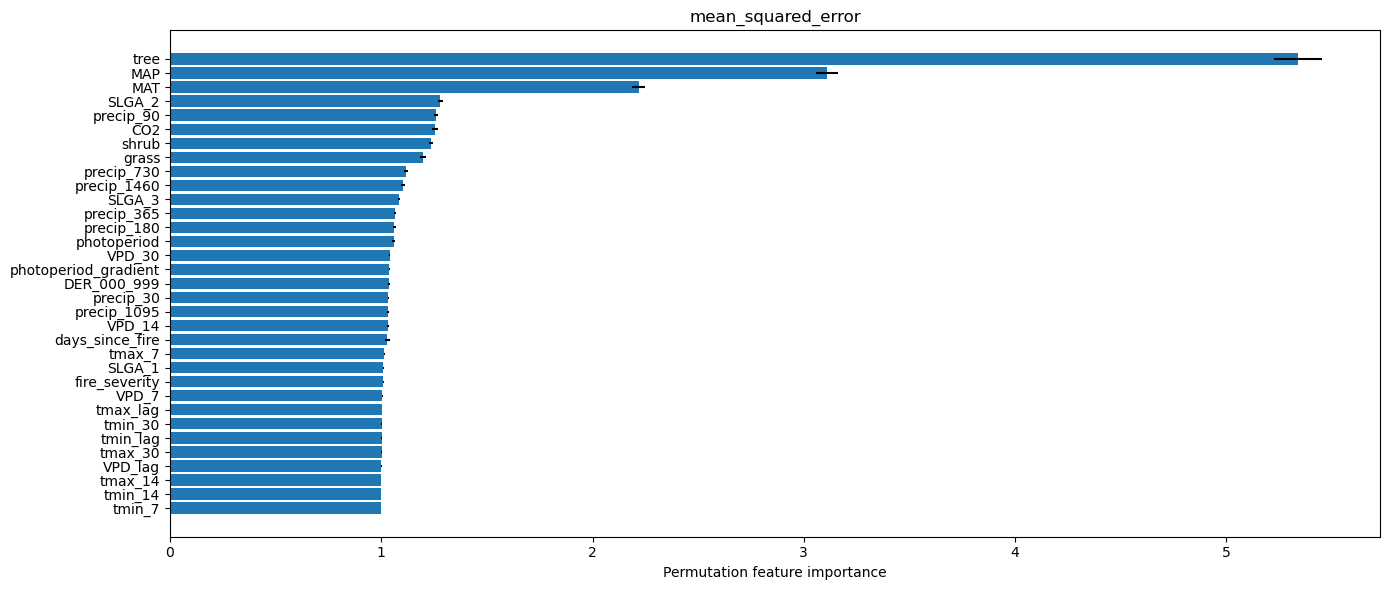

In [7]:
plot_permutation_importance(exp_tree,
                            n_cols=2,
                            fig_kw={'figwidth': 14, 'figheight': 6});

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 17:58:38 2024

@author: krish
"""

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import graphviz 

import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')

from sklearn.ensemble import RandomForestRegressor
import random
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold


#%% Functions 

def plotPredictions(actual, prediction, TARGET, msg = '', split = ''):
    fig, ax = plt.subplots(nrows = 3, figsize = (15,10))
    fig.suptitle(msg, fontsize=30)
    for i,v in enumerate(TARGET):
        actual[v].plot(ax=ax[i], color = 'blue', alpha = 0.4, linestyle='dashed' )
        prediction[f'prediction_{v}'].plot(ax=ax[i], color = 'orange', ylim = (0,100))
        ax[i].legend()
        if split:
            for s in split:
                ax[i].axvline(s, color='black', ls='--')

#%% Main 
# Development (after 2015 set)
after_2015_sites = ['WAAPIL0003', 'NSABHC0023', 'TCATCH0006',
                 'WAAGAS0002', 'NSAMDD0014', 'NTAGFU0021', 
                 'NSANSS0001', 'SATSTP0005', 'QDASSD0015', 
                 'NTAFIN0002', 'NSANAN0002', 'QDAEIU0010'] # smalller subset 


tree_sites = ['NSABBS0001', 'NSACOP0001', 'NSAMDD0011', 'NSAMDD0020',
       'NSAMUL0003', 'NSANAN0001', 'NSANAN0002', 'NSANSS0001',
       'NSANSS0002', 'NSTSYB0003', 'NSTSYB0006', 'NTAFIN0003',
       'NTAFIN0015', 'NTAGFU0030', 'NTAGFU0034', 'QDABBN0002',
       'QDACHC0003', 'QDACYP0020', 'QDAGUP0006', 'QDAMGD0025',
       'QDAMUL0002', 'QDAMUL0003', 'QDASEQ0004', 'SAAFLB0008',
       'SATFLB0003', 'SATFLB0020', 'SATFLB0022', 'TCATCH0004',
       'WAACAR0002', 'WAAGAS0001', 'WAAPIL0023']

shrub_sites = ['NSABHC0011', 'NSAMDD0028', 'NSTSYB0005', 'NTAFIN0018',
       'QDABBS0010', 'QDACYP0018', 'QDAGUP0021', 'SAAEYB0021',
       'SAAEYB0028', 'SAAFLB0005', 'SAAGAW0008', 'SAAKAN0009',
       'SAASTP0023', 'SAASTP0033', 'SAASTP0034', 'SASMDD0009',
       'SASMDD0014', 'SATFLB0023', 'WAACAR0004', 'WAACOO0007',
       'WAACOO0016', 'WAACOO0024', 'WAACOO0026', 'WAACOO0027',
       'WAACOO0029', 'WAAGES0001', 'WAALSD0002', 'WAANUL0003',
       'WAAPIL0010']

grass_sites = ['NSABHC0023', 'NSAMDD0001', 'NSAMDD0014', 'NTADAC0001',
       'NTADMR0001', 'NTAFIN0002', 'NTAFIN0006', 'NTAGFU0014',
       'NTAGFU0020', 'NTAGFU0021', 'NTASTU0004', 'NTTDMR0003',
       'QDABBS0002', 'QDACYP0006', 'QDACYP0022', 'QDAEIU0005',
       'QDAEIU0010', 'QDAGUP0009', 'QDAGUP0019', 'QDAMGD0002',
       'QDAMGD0023', 'QDAMGD0024', 'QDASSD0015', 'SAAEYB0029',
       'SAAFLB0003', 'SASMDD0005', 'SATFLB0019', 'SATSTP0005',
       'TCATCH0006', 'TCATNM0001', 'TCATNM0003', 'VCAAUA0012',
       'WAAAVW0006', 'WAACOO0030', 'WAAGAS0002', 'WAANOK0006',
       'WAAPIL0003', 'WAAPIL0024', 'WAAPIL0031']

sites_list = shrub_sites

#%% Model the dataset

SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30', 'MAT']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

LAG_FEATURES = ['pv_lag', 'npv_lag', 'bs_lag']

LAGGED_CHANGE_FEATURES = ['pv_change', 'npv_change', 'bs_change']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

VEGETATION_FEATURES = ['grass', 'shrub', 'tree']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + TEMP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + VEGETATION_FEATURES + SOIL_FEATURES # final features 
TARGET = ['pv_filter', 'npv_filter', 'bs_filter']
scores = []


#%% Create Train/test set 


# Training and test set 
datasets =  {} # entire set - for final evaluation 
training_set = {} # training set 
test_set = {} # test set 

# 7 years is roughly 20% of the dataset (of n rows)
# i.e. 161 data points 
# A solution is take a random number of the lower bounds (l), such that l >= 0 and l < n - 161
# The upper bounds (u) is simply u = l + 161 

# Iterate through the site list 


random.seed(20240514)

choices = [0, 161, 322, 483, 644] # approx 20% splits 
number_of_choices = len(sites_list)/len(choices)

after_2015_test = False
after_2015_list = list(set(sites_list).intersection(after_2015_sites)) # the sites where I want to predict 2015-2022

duplicator = [round(np.floor(number_of_choices)) for i in range(len(choices))]
print(duplicator)
# If there are specific sites I want as having 2015 >, I need to force some order 
if after_2015_test:
    if duplicator[-1] < len(after_2015_list):
        duplicator[-1] = len(after_2015_list)
    #number_of_choices_adj = (len(sites_list) - len(after_2015_list))/(len(choices) - 1)
    #for i in range(len(choices) - 1):
     #   duplicator[i] = round(np.floor(number_of_choices_adj))

print(duplicator)
already_chosen = []
print(number_of_choices)
while sum(duplicator) != len(sites_list): # if there is an uneven split, keep adding 1 more until it sums to the avaliable number of datasets 
    chosen_index = random.randrange(0,len(duplicator),1)
    if chosen_index not in already_chosen:
        duplicator[chosen_index] += 1
        already_chosen.append(chosen_index)
    #number_of_choices = len(sites_list)/sum(duplicator)

print(duplicator)

choice_adj = []
for index ,i in enumerate(choices):
    for j in range(duplicator[index]):
        choice_adj.append(i)
        
print(choice_adj)
random.shuffle(choice_adj)
print(choice_adj)

if after_2015_test:
    after_2015_indices = [np.where(sites_list == i)[0][0] for i in after_2015_list]
    for i in range(len(after_2015_list)):
        if choice_adj[after_2015_indices[i]] != choices[-1]:
            print(choice_adj) # swap with an element that is 644 and NOT an index of one the after 2015 sites
            index_choices = set(np.where(np.array(choice_adj)== 644)[0]).difference(after_2015_indices)
            swap_index = random.choice(list(index_choices))
            choice_adj[after_2015_indices[i]], choice_adj[swap_index] =  choice_adj[swap_index], choice_adj[after_2015_indices[i]]


period = 161 # approx. 20% 
for i, site_location_name in enumerate(sites_list):
    site_merged = pd.read_csv(f'Input_DataSet_{site_location_name}.csv', parse_dates = ['time']).copy().dropna(subset = FEATURES) # read and drop na
    site_merged.sort_values('time', inplace = True)
    site_merged.reset_index(inplace = True)

    
    lower_bound = choice_adj[i]
    if lower_bound == choices[-1]: # if its the last 20%, simply take all time points from there up to the most recent time point
        upper_bound = len(site_merged) -1
    else:
        upper_bound = lower_bound + period 
        
    print(f'{site_location_name} : {(site_merged.time[lower_bound], site_merged.time[upper_bound])}')
    
    #print((lower_bound, upper_bound))
    # get test set 
    test = site_merged[(site_merged.index >= lower_bound) & (site_merged.index <= upper_bound)]
    # get train set (note the selection condition is logically opposite to selection condition of the test set )
    train = site_merged[(site_merged.index < lower_bound) | (site_merged.index > upper_bound)]
    
    datasets[site_location_name] = site_merged
    training_set[site_location_name] = train
    test_set[site_location_name] = test
    
training_merged = pd.concat(training_set).dropna(subset = FEATURES) # drop na based on chosen features, needed for random forest 
training_merged.sort_values('time', inplace = True)
training_merged.set_index('time', inplace = True)

test_merged = pd.concat(test_set).dropna(subset = FEATURES)
test_merged.sort_values('time', inplace = True)
test_merged.set_index('time', inplace = True)


#%% Run The model 

random_state = 20240228
main_scorer = 'neg_mean_squared_error'
# Possible scorers:
    #  neg_mean_absolute_percentage_error'
    #  mean_squared_log_error
    # See more below:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    

## Test with Default RF 
reg = RandomForestRegressor(n_estimators = 100, random_state = random_state, n_jobs = 7)

# default_RF_CV = pd.DataFrame(cross_validate(reg, X = training_merged[FEATURES],
#                      y = training_merged[TARGET], cv=cv_splits, 
#                      scoring=np.unique(['neg_mean_squared_error', main_scorer]).tolist(),
#                      return_train_score = True))
# print(f'Default\nTrain R2 {default_RF_CV["train_" + "neg_mean_squared_error"].mean()}\nTest R2 {default_RF_CV["test_" + "neg_mean_squared_error"].mean()}')


#%% Fit the Models

# Default Model 

reg.fit(X = training_merged[FEATURES], y = training_merged[TARGET])

[5, 5, 5, 5, 5]
[5, 5, 5, 5, 5]
5.8
[6, 6, 6, 6, 5]
[0, 0, 0, 0, 0, 0, 161, 161, 161, 161, 161, 161, 322, 322, 322, 322, 322, 322, 483, 483, 483, 483, 483, 483, 644, 644, 644, 644, 644]
[0, 644, 644, 161, 322, 483, 644, 322, 161, 0, 161, 0, 322, 483, 322, 483, 0, 161, 0, 0, 483, 483, 644, 161, 322, 644, 483, 322, 161]
NSABHC0011 : (Timestamp('1987-09-28 00:00:00'), Timestamp('1994-10-17 00:00:00'))
NSAMDD0028 : (Timestamp('2015-12-16 00:00:00'), Timestamp('2022-12-19 00:00:00'))
NSTSYB0005 : (Timestamp('2015-12-04 00:00:00'), Timestamp('2022-12-23 00:00:00'))
NTAFIN0018 : (Timestamp('1994-10-19 00:00:00'), Timestamp('2001-11-07 00:00:00'))
QDABBS0010 : (Timestamp('2001-11-11 00:00:00'), Timestamp('2008-11-30 00:00:00'))
QDACYP0018 : (Timestamp('2008-11-14 00:00:00'), Timestamp('2015-12-04 00:00:00'))
QDAGUP0021 : (Timestamp('2015-12-04 00:00:00'), Timestamp('2022-12-23 00:00:00'))
SAAEYB0021 : (Timestamp('2001-11-11 00:00:00'), Timestamp('2008-11-30 00:00:00'))
SAAEYB0028 : (Timestamp(

RandomForestRegressor(n_jobs=7, random_state=20240228)

In [9]:
exp_shrub = pfi.explain(X= np.array(test_merged[FEATURES]),
                  y= np.array(test_merged[TARGET]),
                  method = 'estimate',
                  kind = 'ratio',
                  n_repeats = 50)

100%|██████████| 33/33 [00:24<00:00,  1.33it/s]


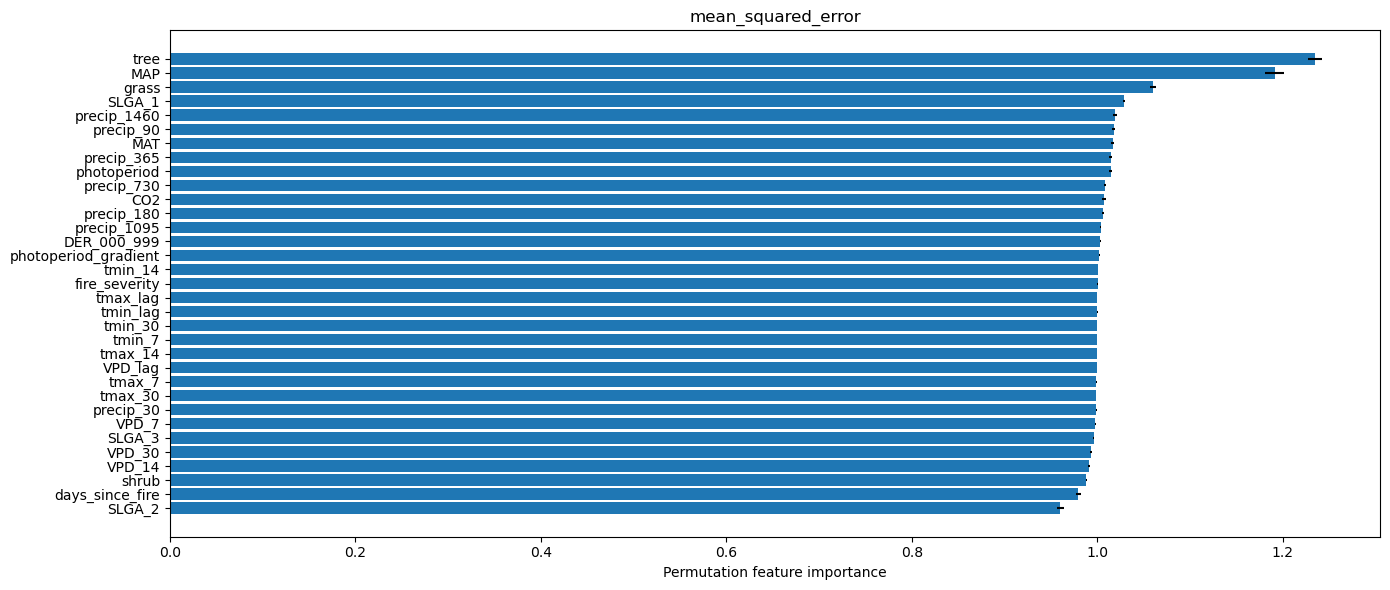

In [10]:
plot_permutation_importance(exp_shrub,
                            n_cols=2,
                            fig_kw={'figwidth': 14, 'figheight': 6});

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  4 17:58:38 2024

@author: krish
"""

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import graphviz 

import sys
sys.path.append('/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/STEP9_DATA_MODELLING_AND_EXPLORATION')

from sklearn.ensemble import RandomForestRegressor
import random
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from PreprocessData import * # import from custom transformers
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold


#%% Functions 

def plotPredictions(actual, prediction, TARGET, msg = '', split = ''):
    fig, ax = plt.subplots(nrows = 3, figsize = (15,10))
    fig.suptitle(msg, fontsize=30)
    for i,v in enumerate(TARGET):
        actual[v].plot(ax=ax[i], color = 'blue', alpha = 0.4, linestyle='dashed' )
        prediction[f'prediction_{v}'].plot(ax=ax[i], color = 'orange', ylim = (0,100))
        ax[i].legend()
        if split:
            for s in split:
                ax[i].axvline(s, color='black', ls='--')

#%% Main 
# Development (after 2015 set)
after_2015_sites = ['WAAPIL0003', 'NSABHC0023', 'TCATCH0006',
                 'WAAGAS0002', 'NSAMDD0014', 'NTAGFU0021', 
                 'NSANSS0001', 'SATSTP0005', 'QDASSD0015', 
                 'NTAFIN0002', 'NSANAN0002', 'QDAEIU0010'] # smalller subset 


tree_sites = ['NSABBS0001', 'NSACOP0001', 'NSAMDD0011', 'NSAMDD0020',
       'NSAMUL0003', 'NSANAN0001', 'NSANAN0002', 'NSANSS0001',
       'NSANSS0002', 'NSTSYB0003', 'NSTSYB0006', 'NTAFIN0003',
       'NTAFIN0015', 'NTAGFU0030', 'NTAGFU0034', 'QDABBN0002',
       'QDACHC0003', 'QDACYP0020', 'QDAGUP0006', 'QDAMGD0025',
       'QDAMUL0002', 'QDAMUL0003', 'QDASEQ0004', 'SAAFLB0008',
       'SATFLB0003', 'SATFLB0020', 'SATFLB0022', 'TCATCH0004',
       'WAACAR0002', 'WAAGAS0001', 'WAAPIL0023']

shrub_sites = ['NSABHC0011', 'NSAMDD0028', 'NSTSYB0005', 'NTAFIN0018',
       'QDABBS0010', 'QDACYP0018', 'QDAGUP0021', 'SAAEYB0021',
       'SAAEYB0028', 'SAAFLB0005', 'SAAGAW0008', 'SAAKAN0009',
       'SAASTP0023', 'SAASTP0033', 'SAASTP0034', 'SASMDD0009',
       'SASMDD0014', 'SATFLB0023', 'WAACAR0004', 'WAACOO0007',
       'WAACOO0016', 'WAACOO0024', 'WAACOO0026', 'WAACOO0027',
       'WAACOO0029', 'WAAGES0001', 'WAALSD0002', 'WAANUL0003',
       'WAAPIL0010']

grass_sites = ['NSABHC0023', 'NSAMDD0001', 'NSAMDD0014', 'NTADAC0001',
       'NTADMR0001', 'NTAFIN0002', 'NTAFIN0006', 'NTAGFU0014',
       'NTAGFU0020', 'NTAGFU0021', 'NTASTU0004', 'NTTDMR0003',
       'QDABBS0002', 'QDACYP0006', 'QDACYP0022', 'QDAEIU0005',
       'QDAEIU0010', 'QDAGUP0009', 'QDAGUP0019', 'QDAMGD0002',
       'QDAMGD0023', 'QDAMGD0024', 'QDASSD0015', 'SAAEYB0029',
       'SAAFLB0003', 'SASMDD0005', 'SATFLB0019', 'SATSTP0005',
       'TCATCH0006', 'TCATNM0001', 'TCATNM0003', 'VCAAUA0012',
       'WAAAVW0006', 'WAACOO0030', 'WAAGAS0002', 'WAANOK0006',
       'WAAPIL0003', 'WAAPIL0024', 'WAAPIL0031']

sites_list = grass_sites

#%% Model the dataset

SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30', 'MAT']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

LAG_FEATURES = ['pv_lag', 'npv_lag', 'bs_lag']

LAGGED_CHANGE_FEATURES = ['pv_change', 'npv_change', 'bs_change']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

VEGETATION_FEATURES = ['grass', 'shrub', 'tree']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + TEMP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + VEGETATION_FEATURES + SOIL_FEATURES # final features 
TARGET = ['pv_filter', 'npv_filter', 'bs_filter']
scores = []


#%% Create Train/test set 


# Training and test set 
datasets =  {} # entire set - for final evaluation 
training_set = {} # training set 
test_set = {} # test set 

# 7 years is roughly 20% of the dataset (of n rows)
# i.e. 161 data points 
# A solution is take a random number of the lower bounds (l), such that l >= 0 and l < n - 161
# The upper bounds (u) is simply u = l + 161 

# Iterate through the site list 


random.seed(20240514)

choices = [0, 161, 322, 483, 644] # approx 20% splits 
number_of_choices = len(sites_list)/len(choices)

after_2015_test = False
after_2015_list = list(set(sites_list).intersection(after_2015_sites)) # the sites where I want to predict 2015-2022

duplicator = [round(np.floor(number_of_choices)) for i in range(len(choices))]
print(duplicator)
# If there are specific sites I want as having 2015 >, I need to force some order 
if after_2015_test:
    if duplicator[-1] < len(after_2015_list):
        duplicator[-1] = len(after_2015_list)
    #number_of_choices_adj = (len(sites_list) - len(after_2015_list))/(len(choices) - 1)
    #for i in range(len(choices) - 1):
     #   duplicator[i] = round(np.floor(number_of_choices_adj))

print(duplicator)
already_chosen = []
print(number_of_choices)
while sum(duplicator) != len(sites_list): # if there is an uneven split, keep adding 1 more until it sums to the avaliable number of datasets 
    chosen_index = random.randrange(0,len(duplicator),1)
    if chosen_index not in already_chosen:
        duplicator[chosen_index] += 1
        already_chosen.append(chosen_index)
    #number_of_choices = len(sites_list)/sum(duplicator)

print(duplicator)

choice_adj = []
for index ,i in enumerate(choices):
    for j in range(duplicator[index]):
        choice_adj.append(i)
        
print(choice_adj)
random.shuffle(choice_adj)
print(choice_adj)

if after_2015_test:
    after_2015_indices = [np.where(sites_list == i)[0][0] for i in after_2015_list]
    for i in range(len(after_2015_list)):
        if choice_adj[after_2015_indices[i]] != choices[-1]:
            print(choice_adj) # swap with an element that is 644 and NOT an index of one the after 2015 sites
            index_choices = set(np.where(np.array(choice_adj)== 644)[0]).difference(after_2015_indices)
            swap_index = random.choice(list(index_choices))
            choice_adj[after_2015_indices[i]], choice_adj[swap_index] =  choice_adj[swap_index], choice_adj[after_2015_indices[i]]


period = 161 # approx. 20% 
for i, site_location_name in enumerate(sites_list):
    site_merged = pd.read_csv(f'Input_DataSet_{site_location_name}.csv', parse_dates = ['time']).copy().dropna(subset = FEATURES) # read and drop na
    site_merged.sort_values('time', inplace = True)
    site_merged.reset_index(inplace = True)

    
    lower_bound = choice_adj[i]
    if lower_bound == choices[-1]: # if its the last 20%, simply take all time points from there up to the most recent time point
        upper_bound = len(site_merged) -1
    else:
        upper_bound = lower_bound + period 
        
    print(f'{site_location_name} : {(site_merged.time[lower_bound], site_merged.time[upper_bound])}')
    
    #print((lower_bound, upper_bound))
    # get test set 
    test = site_merged[(site_merged.index >= lower_bound) & (site_merged.index <= upper_bound)]
    # get train set (note the selection condition is logically opposite to selection condition of the test set )
    train = site_merged[(site_merged.index < lower_bound) | (site_merged.index > upper_bound)]
    
    datasets[site_location_name] = site_merged
    training_set[site_location_name] = train
    test_set[site_location_name] = test
    
training_merged = pd.concat(training_set).dropna(subset = FEATURES) # drop na based on chosen features, needed for random forest 
training_merged.sort_values('time', inplace = True)
training_merged.set_index('time', inplace = True)

test_merged = pd.concat(test_set).dropna(subset = FEATURES)
test_merged.sort_values('time', inplace = True)
test_merged.set_index('time', inplace = True)


#%% Run The model 

random_state = 20240228
main_scorer = 'neg_mean_squared_error'
# Possible scorers:
    #  neg_mean_absolute_percentage_error'
    #  mean_squared_log_error
    # See more below:
    # https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
    

## Test with Default RF 
reg = RandomForestRegressor(n_estimators = 100, random_state = random_state, n_jobs = 7)

# default_RF_CV = pd.DataFrame(cross_validate(reg, X = training_merged[FEATURES],
#                      y = training_merged[TARGET], cv=cv_splits, 
#                      scoring=np.unique(['neg_mean_squared_error', main_scorer]).tolist(),
#                      return_train_score = True))
# print(f'Default\nTrain R2 {default_RF_CV["train_" + "neg_mean_squared_error"].mean()}\nTest R2 {default_RF_CV["test_" + "neg_mean_squared_error"].mean()}')


#%% Fit the Models

# Default Model 

reg.fit(X = training_merged[FEATURES], y = training_merged[TARGET])

[7, 7, 7, 7, 7]
[7, 7, 7, 7, 7]
7.8
[8, 8, 8, 8, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 161, 161, 161, 161, 161, 161, 161, 161, 322, 322, 322, 322, 322, 322, 322, 322, 483, 483, 483, 483, 483, 483, 483, 483, 644, 644, 644, 644, 644, 644, 644]
[322, 0, 161, 161, 322, 483, 483, 322, 0, 161, 483, 644, 483, 483, 161, 644, 0, 322, 0, 644, 483, 161, 322, 0, 322, 322, 0, 322, 644, 644, 161, 0, 0, 644, 644, 161, 483, 483, 161]
NSABHC0023 : (Timestamp('2001-11-05 00:00:00'), Timestamp('2008-11-24 00:00:00'))
NSAMDD0001 : (Timestamp('1987-10-07 00:00:00'), Timestamp('1994-10-26 00:00:00'))
NSAMDD0014 : (Timestamp('1994-10-17 00:00:00'), Timestamp('2001-11-05 00:00:00'))
NTADAC0001 : (Timestamp('1994-10-24 00:00:00'), Timestamp('2001-11-12 00:00:00'))
NTADMR0001 : (Timestamp('2001-10-31 00:00:00'), Timestamp('2008-11-19 00:00:00'))
NTAFIN0002 : (Timestamp('2008-11-19 00:00:00'), Timestamp('2015-12-09 00:00:00'))
NTAFIN0006 : (Timestamp('2008-11-19 00:00:00'), Timestamp('2015-12-09 00:00:00'))
NTAGFU0014 : (

RandomForestRegressor(n_jobs=7, random_state=20240228)

In [12]:
exp_grass = pfi.explain(X= np.array(test_merged[FEATURES]),
                  y= np.array(test_merged[TARGET]),
                  method = 'estimate',
                  kind = 'ratio',
                  n_repeats = 50)

100%|██████████| 33/33 [00:31<00:00,  1.05it/s]


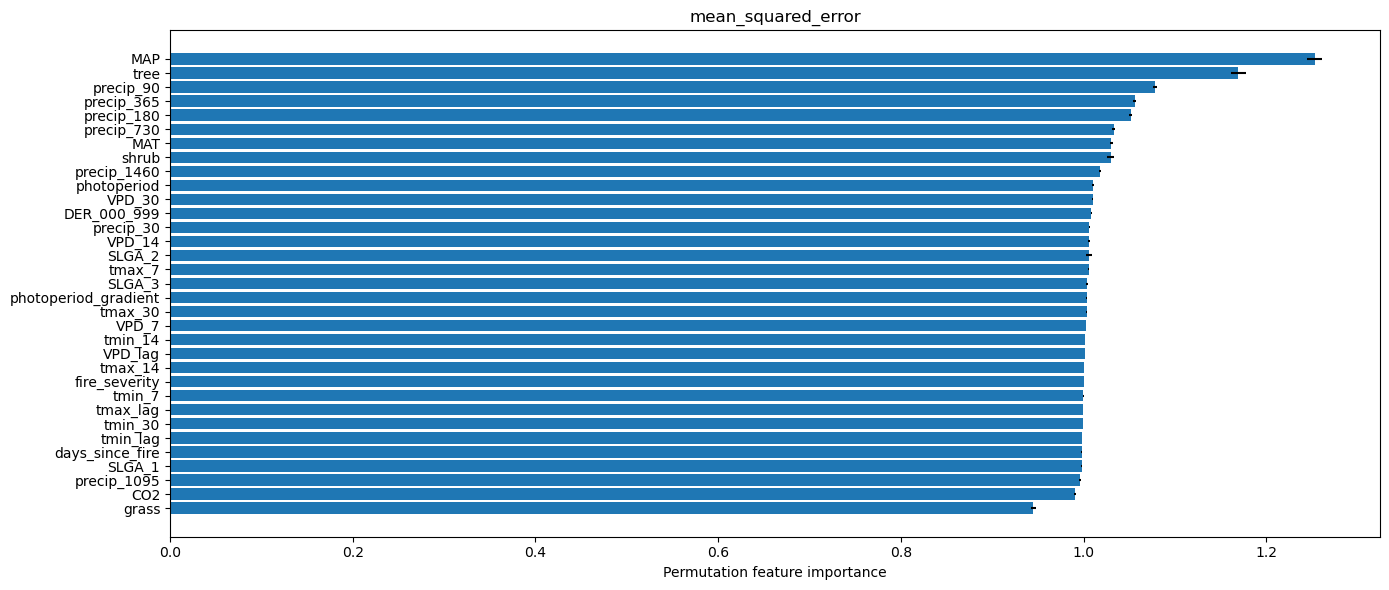

In [13]:
plot_permutation_importance(exp_grass,
                            n_cols=2,
                            fig_kw={'figwidth': 14, 'figheight': 6});